Using Open Bandits Pipeline **[1]**

**[1]** https://arxiv.org/pdf/2008.07146.pdf

/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-06 05:00:35.351970: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 05:00:37.317357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


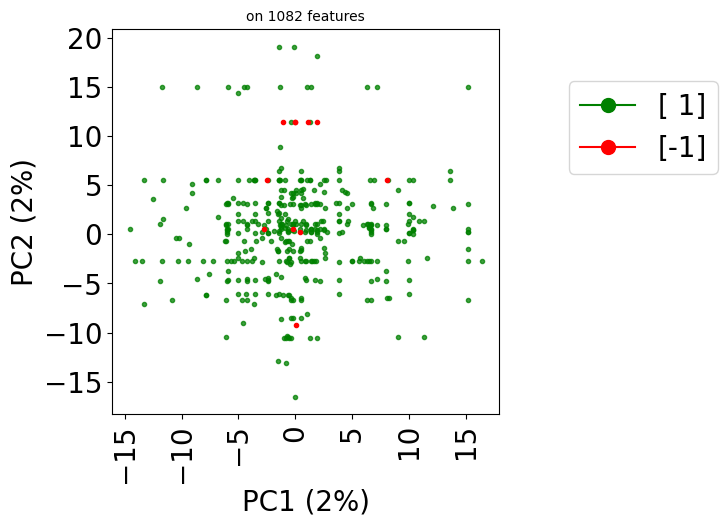

In [1]:
from stanscofi.utils import load_dataset
from stanscofi.datasets import Dataset

## Load dataset
transcript_args = load_dataset("TRANSCRIPT")
transcript_args.update({"name": "TRANSCRIPT", "same_item_user_features": True})
transcript = Dataset(**transcript_args)

transcript.visualize(withzeros=False)

In [2]:
from importlib import reload
import sys
sys.path.insert(0,"src/")
import benchscofi

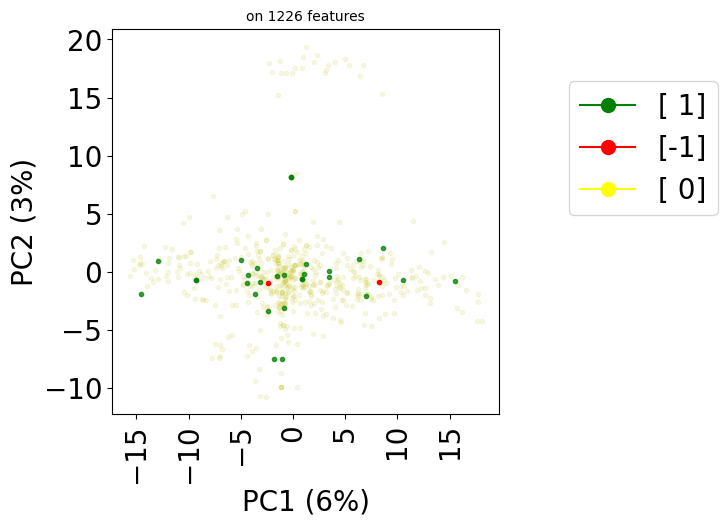

In [3]:
## Restrict to a single disease
import numpy as np

## Which is the disease with the most ratings?
disease_idx = np.argmax(np.abs(transcript.ratings_mat).sum(axis=0))
disease_folds = np.asarray(np.zeros((transcript.ratings_mat.shape[0],3)), dtype=int)
disease_folds[:,0] = disease_idx
disease_folds[:,1] = list(range(transcript.ratings_mat.shape[0]))
disease_folds[:,2] = transcript.ratings_mat[:,disease_idx].ravel()
subset = transcript.get_folds(disease_folds) ## restrict to that disease

subset.visualize(withzeros=True)

In [4]:
## Directly use a_i+theta ~ log(FC) as action feature vectors 
import numpy as np

def same_feature_preprocessing(dataset):
    assert dataset.same_item_user_features
    y = np.ravel(dataset.ratings_mat.flatten())
    S_, P_ = dataset.items.T.copy(), dataset.users.T.copy()
    P_[np.isnan(P_)] = 0
    S_[np.isnan(S_)] = 0
    ids = np.argwhere(np.ones(dataset.ratings_mat.shape)) # (item, user) pairs
    X = np.concatenate(tuple([
        np.add(S_[i, :], P_[j, :]).reshape(-1,1) ## a_i+theta
        for i, j in ids.tolist()
    ]), axis=1).T ## pairs x features
    return X, y

In [5]:
X, y = same_feature_preprocessing(subset)
(X.shape, y.shape)

((613, 12096), (613,))

In [6]:
FeatureDrugs = subset.items.T.copy()
FeatureDiseases = subset.users.T.copy()

## is it sparse?
print("Perc. of zero values in drug feature vector %.2f perc. (N=%d drugs)" 
 % (np.sum(FeatureDrugs==0)*100/(FeatureDrugs.shape[0]*FeatureDrugs.shape[1]), FeatureDrugs.shape[0]))
print("Perc. of zero values in disease feature vector %.2f perc. (N=%d diseases)" 
 % (np.sum(FeatureDiseases==0)*100/(FeatureDiseases.shape[0]*FeatureDiseases.shape[1]), FeatureDiseases.shape[0]))

## do cosine distance scores match reported outcomes?
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr
cos_distances = 1-cosine_similarity(FeatureDrugs, FeatureDiseases)
res = spearmanr(cos_distances[y!=0], y[y!=0])
print("Spearman's r correlation %.3f" % res.correlation)

Perc. of zero values in drug feature vector 45.35 perc. (N=613 drugs)
Perc. of zero values in disease feature vector 95.51 perc. (N=1 diseases)
Spearman's r correlation 0.059


In [ ]:
FeatureDrugs = transcript.items.T.copy()
FeatureDiseases = transcript.users.T.copy()

## is it sparse?
print("Perc. of zero values in drug feature vector %.2f perc. (N=%d drugs)" 
 % (np.sum(FeatureDrugs==0)*100/(FeatureDrugs.shape[0]*FeatureDrugs.shape[1]), FeatureDrugs.shape[0]))
print("Perc. of zero values in disease feature vector %.2f perc. (N=%d diseases)" 
 % (np.sum(FeatureDiseases==0)*100/(FeatureDiseases.shape[0]*FeatureDiseases.shape[1]), FeatureDiseases.shape[0]))

## do cosine distance scores match reported outcomes?
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr
cos_distances = 1-cosine_similarity(FeatureDrugs, FeatureDiseases)
y=transcript.ratings_mat.ravel()
res = spearmanr(cos_distances[y!=0], y[y!=0])
print("Spearman's r correlation %.3f" % res.correlation)

## Direct estimation method

In [9]:
from stanscofi.training_testing import traintest_validation_split, print_folds

random_seed=12345

metric = "cosine" 
test_size = 0.3

## Generates training and testing datasets
train_folds, test_folds, _,_ = traintest_validation_split(transcript, test_size=test_size, early_stop=1, 
                    metric=metric, disjoint_users=False, verbose=False, random_state=random_seed, print_dists=True)

## Prints the contents of the folds
print_folds(train_folds, transcript, "train_folds")
print_folds(test_folds, transcript, "test_folds")

<training_testing.traintest_validation_split> The sets of items/drugs in the training/testing datasets are disjoint.
<training_testing.traintest_validation_split> The sets of users/diseases in the training/testing datasets are *not* disjoint.
<training_testing.traintest_validation_split> Distances:
              Train set  Test set
Train set  1.110223e-16  0.521504
Test set   5.215036e-01  0.199147

<training_testing.print_folds> train_folds: 161 unique drugs and 100 unique diseases and 289 ratings (70.15 perc.)
            0    1  -1
counts  15811  280   9

<training_testing.print_folds> test_folds: 43 unique drugs and 62 unique diseases and 123 ratings (29.85 perc.)
           0    1  -1
counts  2543  121   2


In [10]:
train_dataset = transcript.get_folds(train_folds, subset_name="Train")
test_dataset = transcript.get_folds(test_folds, subset_name="Test")

In [15]:
from time import time
from stanscofi.training_testing import cv_training
from stanscofi.models import LogisticRegression

## Model parameters
params = {"penalty":'elasticnet', "C":1.0, "fit_intercept":True, "class_weight":"balanced", 
          "intercept_scaling":1., "random_state":random_seed, "max_iter":100, "tol": 1e-4, 
          "multi_class":'multinomial', "n_jobs": 1, "l1_ratio":1, "solver": "saga", 
          ## parameter subset allows to only consider Top-N features in terms of cross-sample variance for speed-up 
          "preprocessing": "same_feature_preprocessing", "subset": 10}
params.update({"decision_threshold": 0.})

start=time()

best_estimator = cv_training(LogisticRegression, params, train_dataset, metric="AUC", njobs=1, 
            random_state=random_seed, nsplits=5, show_plots=False, verbose=True)

print("Elapsed time %.3f sec." % (time()-start))
print("AUC on Test %f (Train %f)" % (best_estimator["test_AUC"], best_estimator["train_AUC"]))

0it [00:00, ?it/s]

Crossvalidation step #1/5


/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<validation.compute_metrics> Computed on #users=100, 12 ignored (12 perc)


1it [00:05,  5.97s/it]

<validation.compute_metrics> Computed on #users=100, 59 ignored (59 perc)
Crossvalidation step #2/5


/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<validation.compute_metrics> Computed on #users=100, 14 ignored (14 perc)


2it [00:11,  5.86s/it]

<validation.compute_metrics> Computed on #users=100, 61 ignored (61 perc)
Crossvalidation step #3/5


/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<validation.compute_metrics> Computed on #users=100, 10 ignored (10 perc)


3it [00:17,  5.94s/it]

<validation.compute_metrics> Computed on #users=100, 62 ignored (62 perc)
Crossvalidation step #4/5


/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<validation.compute_metrics> Computed on #users=100, 13 ignored (13 perc)


4it [00:24,  6.35s/it]

<validation.compute_metrics> Computed on #users=100, 59 ignored (59 perc)
Crossvalidation step #5/5


/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<validation.compute_metrics> Computed on #users=100, 9 ignored ( 9 perc)


5it [00:32,  6.52s/it]

<validation.compute_metrics> Computed on #users=100, 64 ignored (64 perc)
Elapsed time 32.638 sec.
AUC on Test 0.500000 (Train 0.500000)


NameError: name 'pd' is not defined

In [17]:
import pandas as pd
pd.DataFrame({"params": best_estimator["model_params"]})

,params
C,1.0
class_weight,balanced
decision_threshold,0.0
fit_intercept,True
intercept_scaling,1.0
l1_ratio,1
max_iter,100
multi_class,multinomial
n_jobs,1
penalty,elasticnet


In [19]:
## Recreate the model
train_train_dataset = train_dataset.get_folds(best_estimator["cv_folds"][0])
model = LogisticRegression(best_estimator["model_params"])
model.fit(train_train_dataset)

/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [21]:
## Predict the model on the testing dataset
scores = model.predict(test_dataset)
model.print_scores(scores)
model.decision_threshold = 0.4
predictions = model.classify(scores)
model.print_classification(predictions)

* Scores
43 unique items, 62 unique users
Scores: Min: 0.397245	Mean: 0.401933	Median: 0.401942	Max: 0.406594	Std: 0.000421

* Classification
43 unique items, 62 unique users
Positive class: 2648, Negative class: 18



<validation.compute_metrics> Computed on #users=62, 2 ignored ( 3 perc)


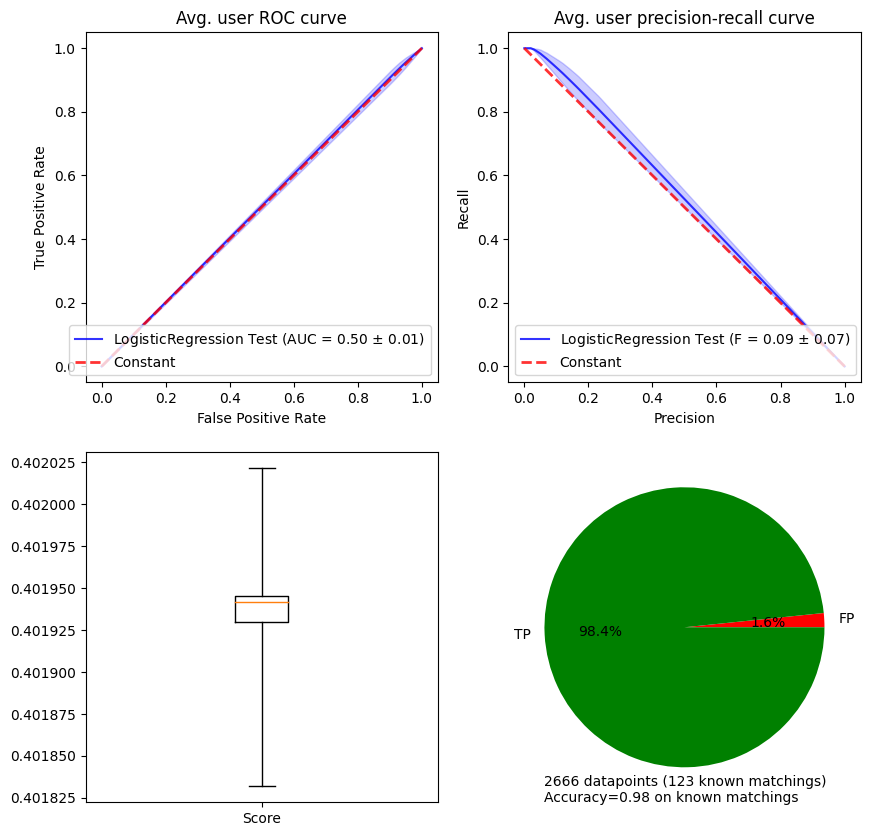

,Avg. across users,Std
AUC,0.503657,0.010227
F_1.0,0.087259,0.071671


In [23]:
from stanscofi.validation import compute_metrics, plot_metrics

## Validate the model on the testing dataset
metrics, plot_args = compute_metrics(scores, predictions, test_dataset, 
                                                          ignore_zeroes=False, verbose=True)
plot_metrics(**plot_args, figsize=(10,10), model_name=model.name+" "+test_dataset.name)
metrics

In [ ]:
## can we overfit?
## same_feature_preprocessing(dataset)
from stanscofi.training_testing import traintest_validation_split
from stanscofi.models import LogisticRegression
from stanscofi.validation import compute_metrics, plot_metrics
import numpy as np

metric = "cosine" 
test_size = 0.955 # max %data manageable by my computer
random_seed=12345

## Reduce size of dataset
train_folds, test_folds, _,_ = traintest_validation_split(transcript, test_size=test_size, early_stop=1, 
                    metric=metric, disjoint_users=False, verbose=False, random_state=random_seed, print_dists=True)
dataset = transcript.get_folds(test_folds, subset_name="Train") 

In [ ]:
## Test with + instead of * in preprocessing
transcript_args = load_dataset("TRANSCRIPT")
transcript_args.update({"name": "exp TRANSCRIPT", "same_item_user_features": True})
transcript_args["users"] = np.exp(transcript_args["users"])
transcript_args["users"] = np.exp(transcript_args["users"])
exp_transcript = Dataset(**transcript_args).get_folds(test_folds)

In [27]:
## Model parameters
params = {"penalty":'elasticnet', "fit_intercept":True, "intercept_scaling":1., "random_state":random_seed, 
          "tol": 1e-4, "multi_class":'multinomial', "n_jobs": 1,"solver": "saga", 
          "preprocessing": "same_feature_preprocessing", 
          
          "subset": 10000, "max_iter":2000, "l1_ratio":0.5, "C":1.0, "class_weight":"balanced",
          
         }
params.update({"decision_threshold": 0.4})

model = LogisticRegression(params)
model.fit(exp_transcript)
scores = model.predict(exp_transcript)
model.print_scores(scores)
metrics, plot_args = compute_metrics(scores, model.classify(scores), transcript, ignore_zeroes=False, verbose=1)
plot_metrics(**plot_args, figsize=(10,10), model_name=model.name+" "+exp_transcript.name)
metrics

<training_testing.traintest_validation_split> The sets of items/drugs in the training/testing datasets are disjoint.
<training_testing.traintest_validation_split> The sets of users/diseases in the training/testing datasets are *not* disjoint.
<training_testing.traintest_validation_split> Distances:
           Train set  Test set
Train set   0.855036  0.913807
Test set    0.913807  0.170059


KeyboardInterrupt: 

In [ ]:
## try with decision tree (hopefully more robust to uninformative features)
from sklearn.ensemble import RandomForestClassifier 
from stanscofi.preprocessing import same_feature_preprocessing

In [ ]:
smaller_dataset = transcript.get_folds(test_folds)
X, y = same_feature_preprocessing(smaller_dataset)
(X.shape, y.shape)

In [ ]:
model = RandomForestClassifier(random_state=random_seed)
model.fit(X, y)
model.score(X, y)

In [ ]:
decision_threshold=0.5
scores = model.predict(X)
predictions = (-1)**(scores>decision_threshold)
metrics, plot_args = compute_metrics(scores, predictions, smaller_dataset, ignore_zeroes=False, verbose=1)
plot_metrics(**plot_args, figsize=(10,10), model_name=model.name+" "+smaller_dataset.name)
metrics

## IPW

In [25]:
from obp.dataset import MultiClassToBanditReduction
from obp.ope import OffPolicyEvaluation, InverseProbabilityWeighting as IPW

In [27]:
random_seed=12345

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

dataset = MultiClassToBanditReduction(X=X, y=y, 
                    base_classifier_b=LogisticRegression(random_state=random_seed))
dataset.split_train_eval(eval_size=0.7, random_state=random_seed)
bandit_feedback = dataset.obtain_batch_bandit_feedback(random_state=random_seed)

# obtain action choice probabilities of an evaluation policy
action_dist = dataset.obtain_action_dist_by_eval_policy(
    base_classifier_e=RandomForestClassifier(random_state=random_seed)
)
# calculate the ground-truth performance of the evaluation policy
ground_truth = dataset.calc_ground_truth_policy_value(action_dist=action_dist)
print("Ground truth perf = %.3f" % ground_truth)

# Off-Policy Evaluation
ope = OffPolicyEvaluation(bandit_feedback=bandit_feedback, ope_estimators=[IPW()])
# evaluate the estimation performance (accuracy) of IPW by the relative estimation 
# error (relative-ee)
relative_estimation_errors = ope.evaluate_performance_of_estimators(
        ground_truth_policy_value=ground_truth,
        action_dist=action_dist,
        metric="relative-ee",
)
print("Relative EE (%s) = %.3f" % [(k,relative_estimation_errors[k])
                                         for k in relative_estimation_errors][0])

Ground truth perf = 0.951
Relative EE (ipw) = 0.955


In [28]:
action_dist.shape ## TODO why 430 down from 613??

(430, 3, 1)